Ibis framework 1.3 was just released, after 8 months of development work with 104 new commits from 16 distinct contributors. What is new? In this blog post we will check some important highlighted features about this new version!

First, if you are new to Ibis framework world, you can check this [blog-post](https://labs.quansight.org/blog/2019/07/ibis-python-data-analysis-productivity-framework/) wrote last year with some introductory information about that.

Some hightlighted features of this new version are:


* Addition of `PySpark` backend
* Improvement of geospatial support
* Addition of `JSON`, `JSONB` and `UUID` data types
* Initial support for `Python 3.8` added.
* Support for `Python 3.5` dropped.
* Added new backends and geospatial methods to the documentation
* Renaming `mapd` backend to `omniscidb`

This blog post is divided into different sections:

* OmniSciDB
* PostgreSQL
* PySpark
* Geospatial support
* Python versions support

In [1]:
import ibis
import pandas as pd

### OmniSciDB notes

Remember, `mapd` backend now is `omniscidb`! 

A important feature on `omniscidb` is that now you can define if the connection is `IPC` and you can also specify the `GPU` device ID you want to use it (if you have a NVIDIA card, supported by `cudf`).

The `IPC` or `Inter-Process Communication` is used to provide shared data support between process. OmniSciDB uses Apache Arrow to provide IPC support.

In [2]:
con_omni = ibis.omniscidb.connect(
    host='localhost', 
    port='6274',
    user='admin',
    password='HyperInteractive',
    database='ibis_testing',
    ipc=False,
    gpu_device=None
)
con_omni.list_tables()

['diamonds', 'batting', 'awards_players', 'functional_alltypes', 'geo']

Also now you can specify `ipc` or `gpu_device` directly to the `execute` method:

In [3]:
t = con_omni.table('functional_alltypes')
expr = t[['id', 'bool_col']].head(5)
df = expr.execute(ipc=False, gpu_device=None)
df

,id,bool_col
0,6690,True
1,6691,False
2,6692,True
3,6693,False
4,6694,True


As you can imagine, the result of `df` is a `pandas.DataFrame` 

In [4]:
type(df)

pandas.core.frame.DataFrame

But if you are using `gpu_device` the result would be a `cudf` :)

<small>

> Note: when IPC=True is used, the code needs to be executed in the same machine where the database is running

> Note: when gpu_device is used, 1) it uses IPC (see the note above) and 2) it needs a NVIDIA card supported by  `cudf`.
</small>

Another interesting feature is that now `omniscidb` also supports `shapefiles` (input) and `geopandas` (output)!

Check out `Geospatial notes` section below to see more details!

Also the new version adds translations for more window operations for `omniscidb` backend, such as: 
`DenseRank`, `RowNumber`, `MinRank`, `Count`, [`PercentRank/CumeDist`](https://github.com/ibis-project/ibis/issues/1975).

For more information about `window operation` check the 
[Window functions](https://docs.ibis-project.org/sql.html#window-functions)
documentation section.

### PostgreSQL notes

Some of the highlighted features for `PostgreSQL` backend are new data types included, such as:
`JSON`, `JSONB` and `UUID`.

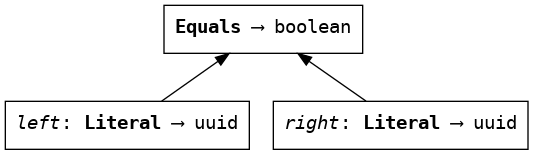

In [5]:
from uuid import uuid4 
uuid_value = ibis.literal(uuid4(), type='uuid')
uuid_value == ibis.literal(uuid4(), type='uuid')

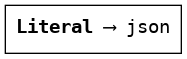

In [6]:
import json
json_value = ibis.literal(json.dumps({"id": 1}), type='json')
json_value

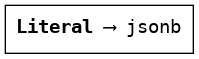

In [7]:
jsonb_value = ibis.literal(json.dumps({"id": 1}).encode('utf8'), type='jsonb')
jsonb_value

Another important new features on `PostgreSQL` backend was some new `geospatial` operations support, such as

* GeometryType
* GeometryN
* IsValid
* LineLocatePoint
* LineMerge
* LineSubstring
* OrderingEquals
* Union

Also, it has now more two geospatial data type support: `MULTIPOINT` and `MULTILINESTRING`.

Check out `Geospatial notes` section below to see some examples of geospatial operations usage!

### PySpark notes

This new version also includes support for a new backend: **PySpark**!

Let's do the first steps with this new backend staring with a Spark session creation.

In [8]:
import os

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.types as pt
from pathlib import Path

# spark session and pyspark connection
spark_session = SparkSession.builder.getOrCreate()
con_pyspark = ibis.pyspark.connect(session=spark_session)

We can use `spark` or `pandas` for reading from `CSV` file. In this example, we will use `pandas`. 

In [9]:
data_directory = Path(
    os.path.join(
        os.path.dirname(ibis.__path__[0]),
        'ci',
        'ibis-testing-data'
    )
)

pd_df_alltypes = pd.read_csv(data_directory / 'functional_alltypes.csv')
pd_df_alltypes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            7300 non-null   int64  
 1   Unnamed: 0       7300 non-null   int64  
 2   id               7300 non-null   int64  
 3   bool_col         7300 non-null   int64  
 4   tinyint_col      7300 non-null   int64  
 5   smallint_col     7300 non-null   int64  
 6   int_col          7300 non-null   int64  
 7   bigint_col       7300 non-null   int64  
 8   float_col        7300 non-null   float64
 9   double_col       7300 non-null   float64
 10  date_string_col  7300 non-null   object 
 11  string_col       7300 non-null   int64  
 12  timestamp_col    7300 non-null   object 
 13  year             7300 non-null   int64  
 14  month            7300 non-null   int64  
dtypes: float64(2), int64(11), object(2)
memory usage: 855.6+ KB


Now, we can create a Spark DataFrame and we will create a temporary view from this data frame. Also we should enforce the desired types for each column.

In [10]:
def pyspark_cast(df, col_types):
    for col, dtype in col_types.items():
        df = df.withColumn(col, df[col].cast(dtype))
    return df

ps_df_alltypes = spark_session.createDataFrame(pd_df_alltypes)

ps_df_alltypes = pyspark_cast(
    ps_df_alltypes, {
        'index': 'integer',
        'Unnamed: 0': 'integer',
        'id': 'integer',
        'bool_col': 'boolean',
        'tinyint_col': 'byte',
        'smallint_col': 'short',
        'int_col': 'integer',
        'bigint_col': 'long',
        'float_col': 'float',
        'double_col': 'double',
        'date_string_col': 'string',
        'string_col': 'string',
        'timestamp_col': 'timestamp',
        'year': 'integer',
        'month': 'integer'
    }
)

# use ``SparkSession`` to create a table
ps_df_alltypes.createOrReplaceTempView('functional_alltypes')
con_pyspark.list_tables()

['functional_alltypes']

Check if all columns were created with the desired data type:

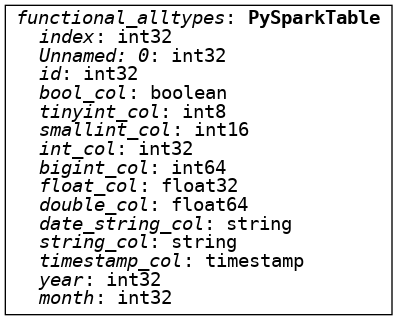

In [11]:
t = con_pyspark.table('functional_alltypes')
t


Different than a `SQL` backend, that returns a `SQL` statement, the returned 
`object` from `pyspark` `compile` method is a `PySpark` `DataFrame`:

In [12]:
expr = t.head()
expr_comp = expr.compile()
type(expr_comp)

pyspark.sql.dataframe.DataFrame

In [13]:
expr_comp

DataFrame[index: int, Unnamed: 0: int, id: int, bool_col: boolean, tinyint_col: tinyint, smallint_col: smallint, int_col: int, bigint_col: bigint, float_col: float, double_col: double, date_string_col: string, string_col: string, timestamp_col: timestamp, year: int, month: int]

To convert the compiled expression to a `Pandas` `DataFrame`, you can use `toPandas` method.
The result should be the same returned by the `execute` method.

In [14]:
assert all(expr.execute() == expr_comp.toPandas())

In [15]:
expr.execute()

,index,Unnamed: 0,id,bool_col,tinyint_col,smallint_col,int_col,bigint_col,float_col,double_col,date_string_col,string_col,timestamp_col,year,month
0,0,0,6690,True,0,0,0,0,0.0,0.0,11/01/10,0,2010-11-01 00:00:00.000,2010,11
1,1,1,6691,False,1,1,1,10,1.1,10.1,11/01/10,1,2010-11-01 00:01:00.000,2010,11
2,2,2,6692,True,2,2,2,20,2.2,20.2,11/01/10,2,2010-11-01 00:02:00.100,2010,11
3,3,3,6693,False,3,3,3,30,3.3,30.3,11/01/10,3,2010-11-01 00:03:00.300,2010,11
4,4,4,6694,True,4,4,4,40,4.4,40.4,11/01/10,4,2010-11-01 00:04:00.600,2010,11


To finish this section, we can play a little bit with some aggregation operations.

In [16]:
expr = t
expr = expr.groupby('string_col').aggregate(
    int_col_mean=t.int_col.mean(),
    int_col_sum=t.int_col.sum(),
    int_col_count=t.int_col.count(),
)
expr.execute()

,string_col,int_col_count,int_col_mean,int_col_sum
0,7,730,7.0,5110
1,3,730,3.0,2190
2,8,730,8.0,5840
3,0,730,0.0,0
4,5,730,5.0,3650
5,6,730,6.0,4380
6,9,730,9.0,6570
7,1,730,1.0,730
8,4,730,4.0,2920
9,2,730,2.0,1460


Check out the `PySpark` `Ibis` backend 
[API documentation](https://docs.ibis-project.org/api.html#pyspark-client-experimental) 
and the [tutorials](https://docs.ibis-project.org/tutorial.html)
for more details.

### Geospatial support notes

Currently, `ibis.omniscidb` and `ibis.postgres` are the only Ibis backends that support `geospatial` features.

In this section we will check some geospatial features using `PostgreSQL` backend.

In [17]:
con_psql = ibis.postgres.connect(
    host='localhost',
    port=5432,
    user='postgres',
    password='postgres',
    database='ibis_testing'
)
con_psql.list_tables()

['array_types',
 'awards_players',
 'batting',
 'diamonds',
 'films',
 'functional_alltypes',
 'geo',
 'geography_columns',
 'geometry_columns',
 'intervals',
 'not_supported_intervals',
 'raster_columns',
 'raster_overviews',
 'spatial_ref_sys',
 'tzone']

Two important features are that it support `shape` objects (input) and `geopandas` dataframe (output)! 

So, let's import `shapely` to create a simple `shape` point and polygon.

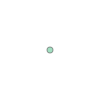

In [18]:
import shapely

shp_point = shapely.geometry.Point((20, 10))
shp_point

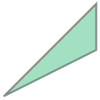

In [19]:
shp_polygon_1 = shapely.geometry.Polygon([(20, 10), (40, 30), (40, 20), (20, 10)])
shp_polygon_1

Now, let's create a Ibis table expression to manipulate `geo` table:

In [20]:
t_geo = con_psql.table('geo')
df_geo = t_geo.execute()
df_geo

,id,geo_point,geo_linestring,geo_polygon,geo_multipolygon
0,1,POINT (0.00000 0.00000),"LINESTRING (0 0, 1 1)","POLYGON ((30 10, 40 40, 20 40, 10 20, 30 10))","(POLYGON ((30 20, 45 40, 10 40, 30 20)), POLYG..."
1,2,POINT (1.00000 1.00000),"LINESTRING (1 1, 2 2)","POLYGON ((35 10, 45 45, 15 40, 10 20, 35 10), ...","(POLYGON ((40 40, 20 45, 45 30, 40 40)), POLYG..."
2,3,POINT (2.00000 2.00000),"LINESTRING (2 2, 3 3)","POLYGON ((2 2, 3 3, 4 4, 5 5, 5 2, 2 2))","(POLYGON ((2 2, 3 3, 4 4, 5 5, 5 2, 2 2)))"
3,4,POINT (3.00000 3.00000),"LINESTRING (3 3, 4 4)","POLYGON ((3 3, 4 4, 5 5, 6 6, 6 3, 3 3))","(POLYGON ((3 3, 4 4, 5 5, 6 6, 6 3, 3 3)))"
4,5,POINT (4.00000 4.00000),"LINESTRING (4 4, 5 5)","POLYGON ((4 4, 5 5, 6 6, 7 7, 7 4, 4 4))","(POLYGON ((4 4, 5 5, 6 6, 7 7, 7 4, 4 4)))"


And the type of `df_geo` is ...  a `geopandas` dataframe!

In [21]:
type(df_geo)

geopandas.geodataframe.GeoDataFrame

So you can take the advantage of `GeoPandas` features too!

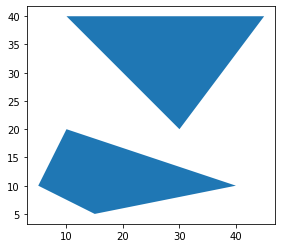

In [22]:
df_geo.set_geometry('geo_multipolygon').head(1).plot();

Now, let's check if there are any `geo_multipolygon` that contains the `shape` point we just created. 

In [23]:
t_geo[
    t_geo.geo_multipolygon, 
    t_geo['geo_multipolygon'].contains(shp_point).name('contains_point_1')
].execute()

,geo_multipolygon,contains_point_1
0,"MULTIPOLYGON (((30.00000 20.00000, 45.00000 40...",True
1,"MULTIPOLYGON (((40.00000 40.00000, 20.00000 45...",True
2,"MULTIPOLYGON (((2.00000 2.00000, 3.00000 3.000...",False
3,"MULTIPOLYGON (((3.00000 3.00000, 4.00000 4.000...",False
4,"MULTIPOLYGON (((4.00000 4.00000, 5.00000 5.000...",False


So, as expected, just the first two `multipolygons` contain a `point` with coordinates `(20, 10)`.

For more examples about **Geospatial Analysis** with `Ibis`, 
check this nice [tutorial](https://docs.ibis-project.org/notebooks/tutorial/11-Geospatial-Analysis.html)
wrote by [Ian Rose](https://github.com/ian-r-rose)!

### Python versions support notes

Ibis-framework 1.3 added a initially support for `Python 3.8` and 
dropped support for `Python 3.5`. 

> Note: currently, [OmniSciDB](https://github.com/ibis-project/ibis/issues/2090) and 
[PySpark](https://github.com/ibis-project/ibis/issues/2091) ``Ibis`` backends
are not supported on `Python 3.8`.

### Final words

**Do you want to play more with Ibis framework?**

You can install it from `PyPI`

```
python -m pip install --upgrade ibis-framework==1.3.0
```

Or from `conda-forge`

```
conda install ibis-framework=1.3.0 -c conda-forge
```

Check out some interesting tutorials to help you to start on Ibis: https://docs.ibis-project.org/tutorial.html

If you are coming from the `SQL` world, maybe [Ibis for SQL Programmers](https://docs.ibis-project.org/sql.html) 
documentation section would be very helpful!

Have fun!
